In [1]:
import os
import json
import os.path as osp
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import utils

db_dir = osp.abspath(osp.join('..', 'db-checkpoints'))
assert osp.exists(db_dir)
# os.listdir(db_dir)
path = osp.join(db_dir, 'db-2024-08-17:11:04.sqlite3')
assert osp.exists(path)

sql_query = '''SELECT w.id,
	 w.result_id,
	 a_800,
	 auc,
	 k,
	 rsq,
	 concentration,
	 volume,
	 address,
	 file,
	 ligand,
	 control,
	 w.comment as well_comment,
	 exclude,
	 rc.comment as result_comment
    FROM "wells" w
    LEFT JOIN "result_comments" rc
        ON w.result_id = rc.result_id
'''

with sqlite3.connect(path) as con:
    df = pd.read_sql(sql_query, con)

df

,id,result_id,a_800,auc,k,rsq,concentration,volume,address,file,ligand,control,well_comment,exclude,result_comment
0,1,1,0.025,7.928611,4.550218e+09,None,None,None,A1,None,None,0,None,1,None
1,2,1,0.022,7.942496,4.572193e+09,None,None,None,C1,None,None,0,None,0,None
2,3,1,0.022,9.492831,4.583432e+09,None,None,None,E1,None,None,0,None,0,None
3,4,1,0.018,8.396640,4.489763e+09,None,None,None,G1,None,None,0,None,0,None
4,5,1,0.021,7.221014,4.453098e+09,None,None,None,I1,None,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,15004,938,0.090,12.954521,1.439930e+09,None,None,None,L24,None,None,1,None,0,no response
18572,15005,938,0.061,11.020645,1.321902e+09,None,None,None,M24,None,None,1,None,0,no response
18573,15006,938,0.042,14.129425,1.733233e+09,None,None,None,N24,None,None,1,None,0,no response
18574,15007,938,0.042,18.482011,2.186354e+09,None,None,None,O24,None,None,1,None,0,no response


In [2]:
print(f"Percentage of wells excluded: {df['exclude'].sum() / len(df['id'].unique()):.2%}")

Percentage of wells excluded: 7.56%


## Data Issues

Empty Fields

In [3]:
df.count()

id                18576
result_id         18576
a_800             18576
auc               18576
k                 18576
rsq                   0
concentration         0
volume                0
address           18576
file                  0
ligand                0
control           18576
well_comment         68
exclude           18576
result_comment    12192
dtype: int64

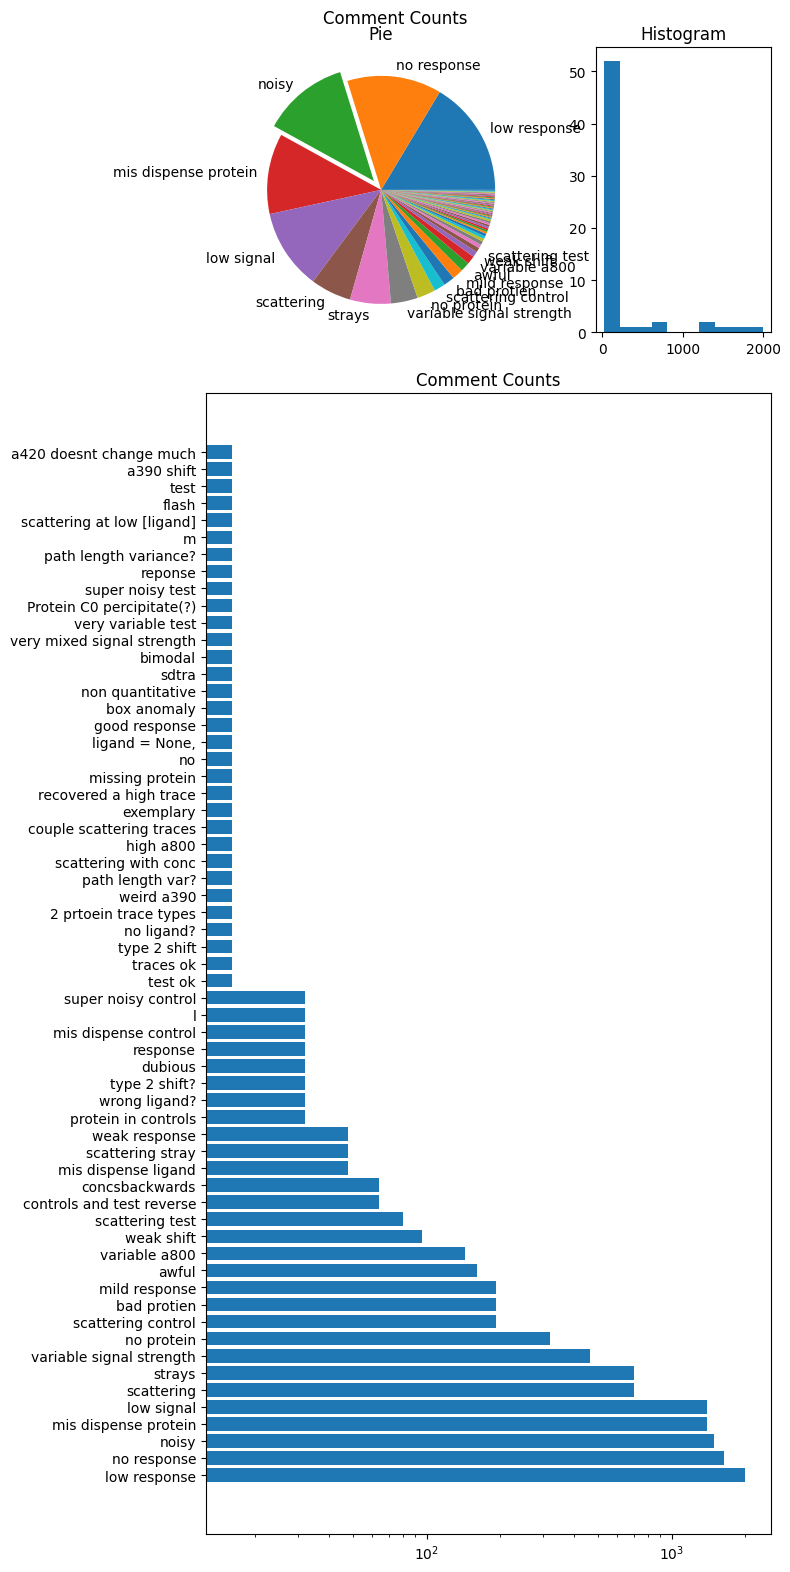

In [4]:
comment_counts = df['result_comment'].value_counts()

fig = plt.figure(figsize=(8, 16))

grid = fig.add_gridspec(2, 2,
                       height_ratios=[1, 4],
                       width_ratios=[2, 1],
                       )

ax1 = fig.add_subplot(grid[0, 0])

ax1.pie(comment_counts,
                  labels=[i  if comment_counts[i] > 64 else None for i in comment_counts.index],
                  explode=[0.1  if i == 'noisy' else 0 for i in comment_counts.index]
                 )
ax1.set_title('Pie')


ax2 = fig.add_subplot(grid[0, 1])
ax2.hist(comment_counts)
ax2.set_title('Histogram')

ax3 = fig.add_subplot(grid[1, :])
ax3.barh(y=comment_counts.index,
         width=comment_counts,
         log=True,
         )
ax3.set_title('Comment Counts')

fig.suptitle('Comment Counts')

plt.tight_layout()
plt.show()

In [5]:
test = df.query('control == 0 and exclude == 0')
control = df.query('control == 1 and exclude == 0')

excluded = df.query('exclude == 1')
mis_dispense = excluded.loc[excluded['result_comment'] == 'mis dispense protein', :]
mis_dispense = df.query('exclude == 1 and control == 0 and result_comment == "mis dispense protein"')

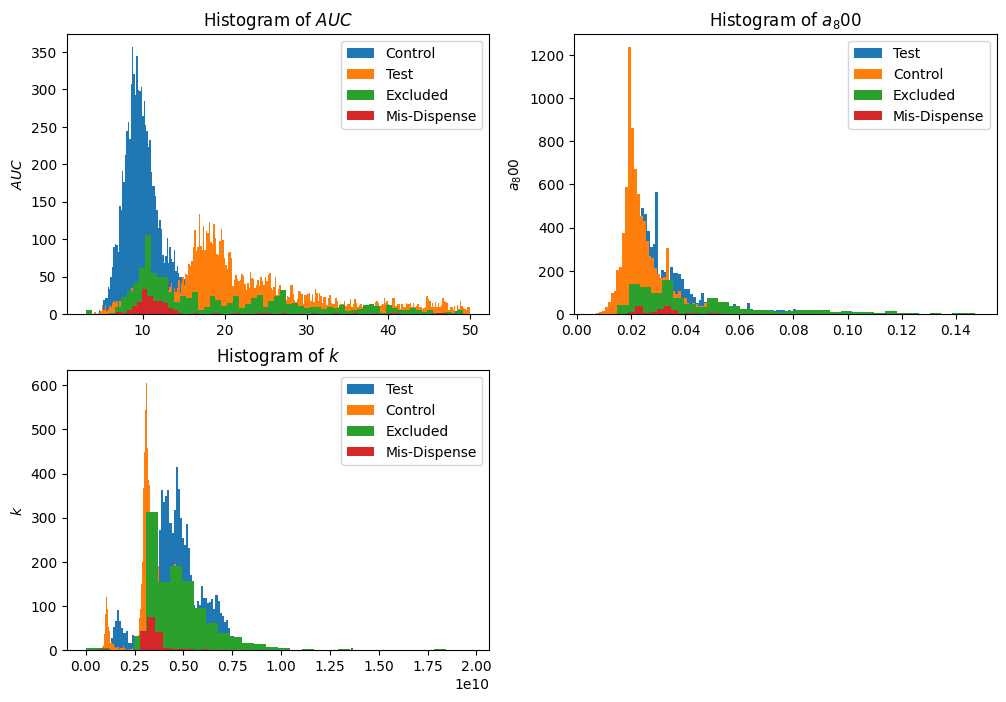

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0, 0].hist(control['auc'].loc[control['auc'] < 50], bins=256, label='Control')
ax[0, 0].hist(test['auc'].loc[test['auc'] < 50], bins=256, label='Test')
ax[0, 0].hist(excluded['auc'].loc[excluded['auc'] < 50], bins=64, label='Excluded')
ax[0, 0].hist(mis_dispense['auc'].loc[mis_dispense['auc'] < 50], bins=64, label='Mis-Dispense')
ax[0, 0].set_ylabel('$AUC$')
ax[0, 0].set_title('Histogram of $AUC$')
ax[0, 0].legend()

ax[0, 1].hist(test['a_800'].loc[test['a_800'] < 0.15], bins=128, label='Test')
ax[0, 1].hist(control['a_800'].loc[control['a_800'] < 0.15], bins=128, label='Control')
ax[0, 1].hist(excluded['a_800'].loc[excluded['a_800'] < 0.15], bins=32, label='Excluded')
ax[0, 1].hist(mis_dispense['a_800'].loc[mis_dispense['a_800'] < 0.15], bins=32, label='Mis-Dispense')
ax[0, 1].legend()
ax[0, 1].set_ylabel('$a_800$')
ax[0, 1].set_title('Histogram of $a_800$')

ax[1, 0].hist(test['k'], bins=128, label='Test')
ax[1, 0].hist(control['k'], bins=128, label='Control')
ax[1, 0].hist(excluded['k'], bins=32, label='Excluded')
ax[1, 0].hist(mis_dispense['k'], bins=32, label='Mis-Dispense')
ax[1, 0].set_ylabel('$k$')
ax[1, 0].set_title('Histogram of $k$')
ax[1, 0].legend()
ax[1, 1].axis('off')

plt.show()

## Exclude Mis-Dispensed Protein

Traces are similar to controls,  $AUC$ and $K$ are similar to controls.

In [7]:
[i for i in comment_counts.index if 'ligand' in i]

['mis dispense ligand',
 'wrong ligand?',
 'no ligand?',
 'ligand = None,',
 'scattering at low [ligand]']

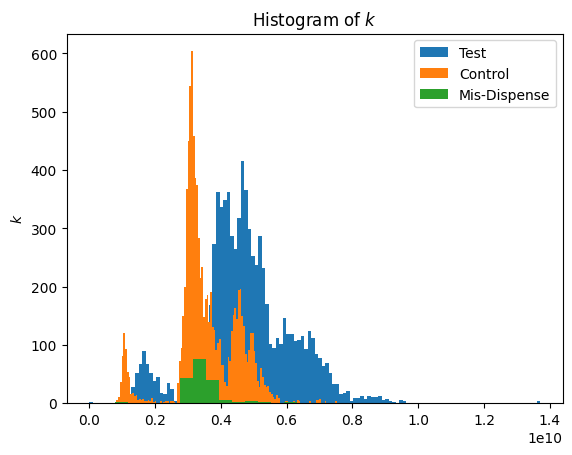

In [8]:
plt.hist(test['k'], bins=128, label='Test')
plt.hist(control['k'], bins=128, label='Control')
plt.hist(mis_dispense['k'], bins=32, label='Mis-Dispense')
plt.ylabel('$k$')
plt.title('Histogram of $k$')
plt.legend()

plt.show()

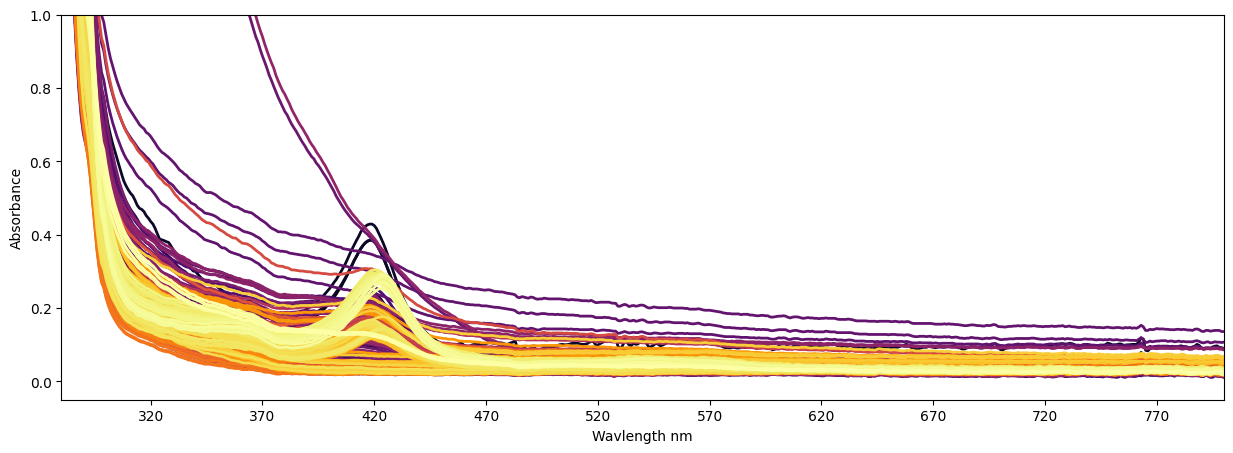

In [19]:
sql_query = """SELECT * FROM wells where exclude = true """

with sqlite3.connect('/home/james/thesis-stuff/old/201906_P450_PlateAssay_Development/db.sqlite3') as con:
    df = pd.read_sql(sql_query, con)
    
excluded_wells = pd.json_normalize(df['raw_data'].apply(json.loads))

df.drop('raw_data', axis=1, inplace=True)
utils.plot.plot_plate_data(excluded_wells, legend=False)

In [20]:
df

,id,result_id,a_800,auc,k,rsq,concentration,volume,address,file,ligand,control,comment,exclude
0,1,1,0.059,25.465750,5.492353e+09,0.555967,500.000000,500.000000,A13,/home/james/thesis-stuff/old/201906_P450_Plate...,None,0,None,1
1,132,9,0.022,21.291793,5.219053e+09,0.534129,62.500000,62.500000,G2,/home/james/thesis-stuff/old/201906_P450_Plate...,Arachadionic Acid,0,None,1
2,278,18,0.026,19.122088,4.985858e+09,0.522011,15.625000,15.625000,K11,/home/james/thesis-stuff/old/201906_P450_Plate...,Palmitic Acid,0,None,1
3,284,18,0.016,12.347363,4.586372e+09,0.478980,62.500000,62.500000,H11,/home/james/thesis-stuff/old/201906_P450_Plate...,Palmitic Acid,1,None,1
4,285,18,0.017,12.466830,4.511466e+09,0.481905,31.250000,31.250000,J11,/home/james/thesis-stuff/old/201906_P450_Plate...,Palmitic Acid,1,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,6744,424,0.025,28.170487,5.387097e+09,0.665233,500.000000,500.000000,H1,/home/james/thesis-stuff/old/201906_P450_Plate...,Arachadionic acid,0,None,1
371,6758,425,0.024,27.973214,5.013162e+09,0.664762,182.215743,182.215743,N1,/home/james/thesis-stuff/old/201906_P450_Plate...,Arachadionic acid,0,None,1
372,6760,425,0.023,29.047448,5.419114e+09,0.668100,500.000000,500.000000,P1,/home/james/thesis-stuff/old/201906_P450_Plate...,Arachadionic acid,0,None,1
373,6776,426,0.026,29.294491,5.502300e+09,0.673884,500.000000,500.000000,H3,/home/james/thesis-stuff/old/201906_P450_Plate...,Arachadionic acid,0,None,1


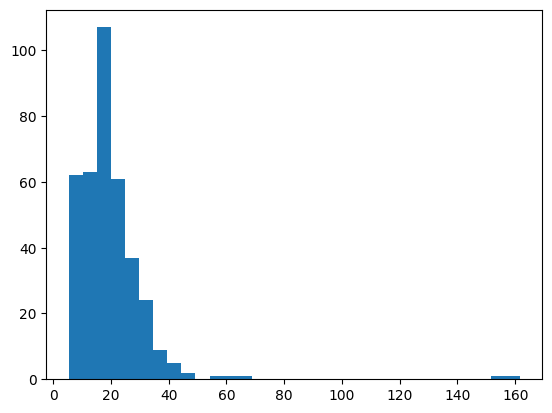

In [22]:
plt.hist(df['auc'], bins=32)
plt.show()

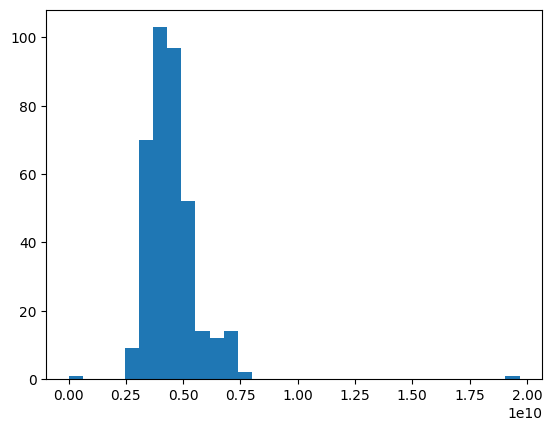

In [24]:
plt.hist(df['k'], bins=32)
plt.show()

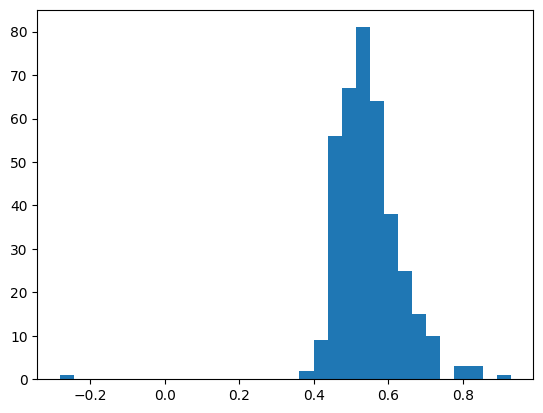

In [25]:
plt.hist(df['rsq'], bins=32)
plt.show()

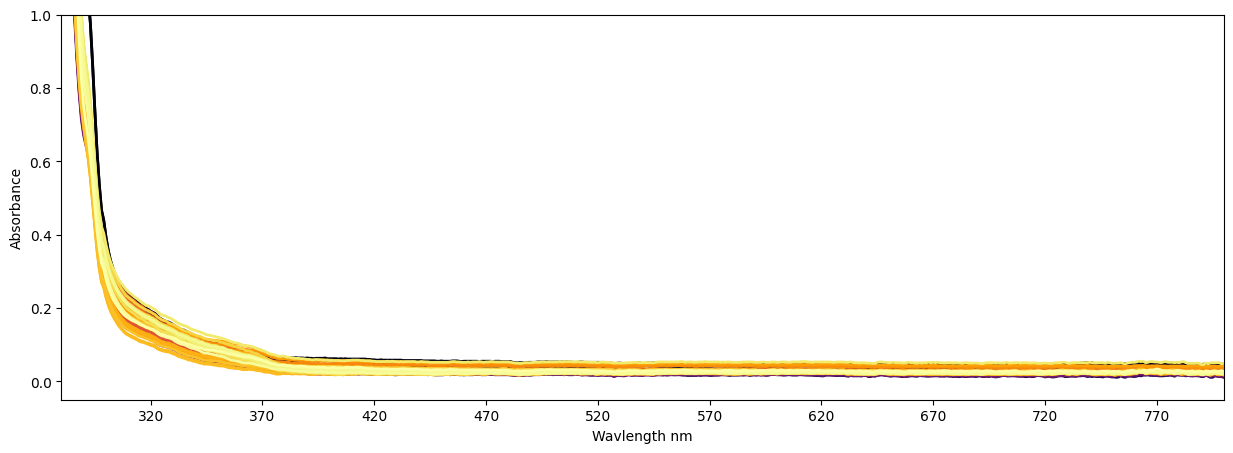

In [27]:
utils.plot.plot_plate_data(excluded_wells.loc[df['auc'] < 12, :], legend=False)

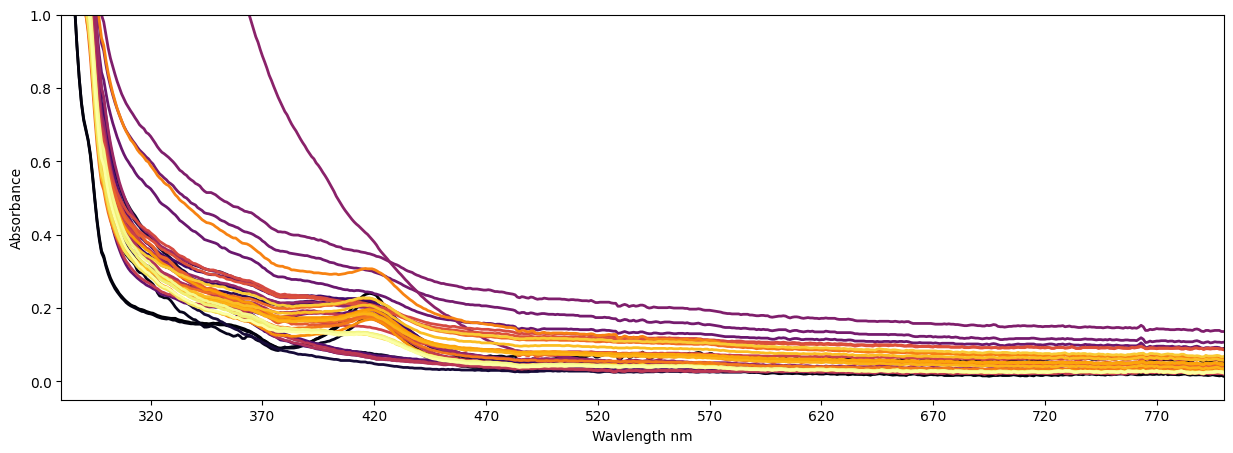

In [45]:
utils.plot.plot_plate_data(excluded_wells.loc[df.query('rsq > 0.6 & k > 5e9').index, :], legend=False)

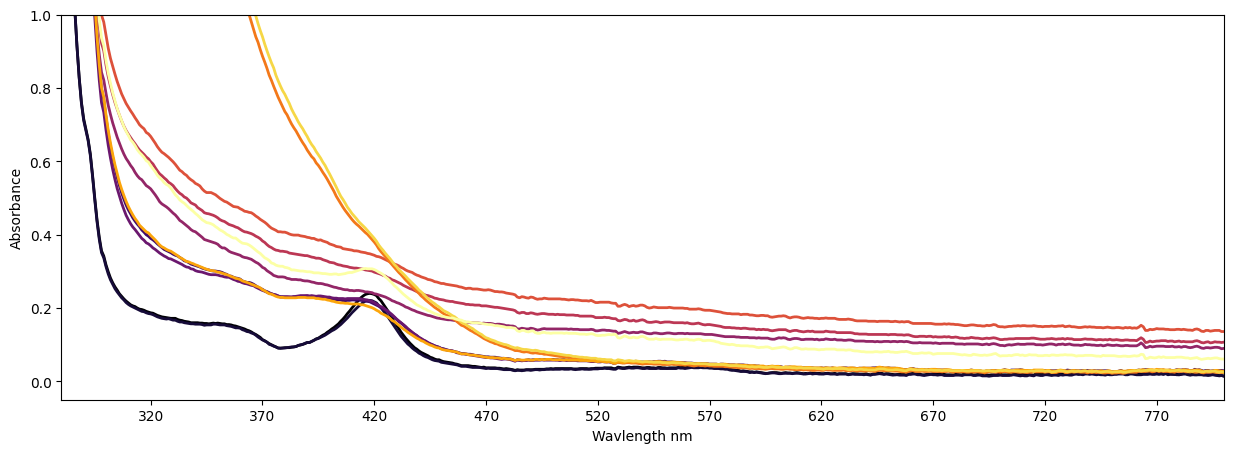

In [48]:
utils.plot.plot_plate_data(excluded_wells.loc[df.query('auc > 40').index, :], legend=False)